In [1]:
# Only with Google colab
import sys
from google.colab import drive
drive.mount('/content/gdrive')
sys.path.append("/content/gdrive/My Drive/Colab Notebooks")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


# Imports

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.callbacks import History, ModelCheckpoint, EarlyStopping
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
from keras.applications import VGG16

from utils import load_images, plot_accuracy_and_loss, plot_confusion_matrix, plot_smoothed_acc_and_loss, extract_features

Using TensorFlow backend.


# Parameters

In [2]:
train_dir = 'images_small/train/'
validation_dir = 'images_small/validation/'
test_dir = 'images_small/test/'

STD_SIZE = (100, 100)
BATCH_SIZE = 20
ENVIRONNEMENT = 'local'

if ENVIRONNEMENT == 'colab':
    PATH = '/content/gdrive/My Drive/Colab Notebooks/'
else:
    PATH = ''

# 2 breeds

### Data preparation

In [15]:
classes = ['Chihuahua', 'Japanese_spaniel']

train_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    PATH + train_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=classes)

validation_generator = test_datagen.flow_from_directory(
    PATH + validation_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=classes)

test_generator = test_datagen.flow_from_directory(
    PATH + test_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=classes)

# Get class labels
inv_class_indices = {v: k for k, v in train_generator.class_indices.items()}
classes_labels = []
for i in range(len(inv_class_indices)):
    classes_labels.append(inv_class_indices[i])
print('\nStored classes labels in classes_labels: ', classes_labels)

Found 202 images belonging to 2 classes.
Found 67 images belonging to 2 classes.
Found 68 images belonging to 2 classes.

Stored classes labels in classes_labels:  ['Chihuahua', 'Japanese_spaniel']


### Model

In [16]:
conv_base = VGG16(weights='imagenet', 
                  include_top = False,
                  input_shape = (STD_SIZE[0], STD_SIZE[1], 3))

In [17]:
train_features, train_labels = extract_features(
    generator=train_generator, 
    feature_size=(3, 3, 512), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels),
    model=conv_base)

validation_features, validation_labels = extract_features(
    generator=validation_generator, 
    feature_size=(3, 3, 512), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels),
    model=conv_base)

test_features, test_labels = extract_features(
    generator=test_generator, 
    feature_size=(3, 3, 512), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels),
    model=conv_base)

train_features = np.reshape(train_features, (-1, 3 * 3 * 512))
validation_features = np.reshape(validation_features, (-1, 3 * 3 * 512))
test_features = np.reshape(test_features, (-1, 3 * 3 * 512))

In [18]:
model = Sequential()
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=1e-5),
              metrics=['accuracy'])

history = model.fit(
    train_features, train_labels,
    epochs=1000, batch_size=BATCH_SIZE, verbose=2,
    validation_data=(validation_features, validation_labels),
    callbacks=[History(),
               ModelCheckpoint(PATH + 'tl_freeze_conv_base_2', monitor='val_loss', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True, verbose=1)
              ])

with open(PATH + 'tl_freeze_conv_base_2_history', 'wb') as f:
    pickle.dump(history.history, f)

Train on 202 samples, validate on 67 samples
Epoch 1/1000
 - 0s - loss: 0.8494 - acc: 0.4505 - val_loss: 0.7154 - val_acc: 0.5522

Epoch 00001: val_loss improved from inf to 0.71538, saving model to tl_freeze_conv_base_2
Epoch 2/1000
 - 0s - loss: 0.7580 - acc: 0.5347 - val_loss: 0.6755 - val_acc: 0.6269

Epoch 00002: val_loss improved from 0.71538 to 0.67554, saving model to tl_freeze_conv_base_2
Epoch 3/1000
 - 0s - loss: 0.7194 - acc: 0.6139 - val_loss: 0.6452 - val_acc: 0.6866

Epoch 00003: val_loss improved from 0.67554 to 0.64525, saving model to tl_freeze_conv_base_2
Epoch 4/1000
 - 0s - loss: 0.7253 - acc: 0.5792 - val_loss: 0.6187 - val_acc: 0.7164

Epoch 00004: val_loss improved from 0.64525 to 0.61874, saving model to tl_freeze_conv_base_2
Epoch 5/1000
 - 0s - loss: 0.6660 - acc: 0.5941 - val_loss: 0.5996 - val_acc: 0.6866

Epoch 00005: val_loss improved from 0.61874 to 0.59956, saving model to tl_freeze_conv_base_2
Epoch 6/1000
 - 0s - loss: 0.6198 - acc: 0.6634 - val_loss:

 - 0s - loss: 0.2236 - acc: 0.9455 - val_loss: 0.2610 - val_acc: 0.9104

Epoch 00047: val_loss improved from 0.26290 to 0.26102, saving model to tl_freeze_conv_base_2
Epoch 48/1000
 - 0s - loss: 0.2432 - acc: 0.9208 - val_loss: 0.2590 - val_acc: 0.9104

Epoch 00048: val_loss improved from 0.26102 to 0.25905, saving model to tl_freeze_conv_base_2
Epoch 49/1000
 - 0s - loss: 0.2425 - acc: 0.9158 - val_loss: 0.2550 - val_acc: 0.9104

Epoch 00049: val_loss improved from 0.25905 to 0.25504, saving model to tl_freeze_conv_base_2
Epoch 50/1000
 - 0s - loss: 0.2091 - acc: 0.9455 - val_loss: 0.2476 - val_acc: 0.9403

Epoch 00050: val_loss improved from 0.25504 to 0.24757, saving model to tl_freeze_conv_base_2
Epoch 51/1000
 - 0s - loss: 0.2057 - acc: 0.9505 - val_loss: 0.2464 - val_acc: 0.9403

Epoch 00051: val_loss improved from 0.24757 to 0.24635, saving model to tl_freeze_conv_base_2
Epoch 52/1000
 - 0s - loss: 0.2151 - acc: 0.9208 - val_loss: 0.2535 - val_acc: 0.9104

Epoch 00052: val_loss 

 - 0s - loss: 0.0961 - acc: 0.9901 - val_loss: 0.2075 - val_acc: 0.8955

Epoch 00099: val_loss did not improve from 0.20244
Epoch 100/1000
 - 0s - loss: 0.1029 - acc: 0.9851 - val_loss: 0.2046 - val_acc: 0.8955

Epoch 00100: val_loss did not improve from 0.20244
Epoch 101/1000
 - 0s - loss: 0.0898 - acc: 0.9901 - val_loss: 0.2039 - val_acc: 0.8955

Epoch 00101: val_loss did not improve from 0.20244
Epoch 102/1000
 - 0s - loss: 0.0863 - acc: 0.9950 - val_loss: 0.2021 - val_acc: 0.8955

Epoch 00102: val_loss improved from 0.20244 to 0.20212, saving model to tl_freeze_conv_base_2
Epoch 103/1000
 - 0s - loss: 0.0781 - acc: 0.9950 - val_loss: 0.2011 - val_acc: 0.8955

Epoch 00103: val_loss improved from 0.20212 to 0.20113, saving model to tl_freeze_conv_base_2
Epoch 104/1000
 - 0s - loss: 0.0867 - acc: 0.9851 - val_loss: 0.2020 - val_acc: 0.8955

Epoch 00104: val_loss did not improve from 0.20113
Epoch 105/1000
 - 0s - loss: 0.0833 - acc: 0.9901 - val_loss: 0.2015 - val_acc: 0.8955

Epoch 0

 - 0s - loss: 0.0401 - acc: 1.0000 - val_loss: 0.2011 - val_acc: 0.8955

Epoch 00155: val_loss did not improve from 0.19763
Epoch 156/1000
 - 0s - loss: 0.0376 - acc: 1.0000 - val_loss: 0.2008 - val_acc: 0.8955

Epoch 00156: val_loss did not improve from 0.19763
Epoch 157/1000
 - 0s - loss: 0.0351 - acc: 1.0000 - val_loss: 0.2014 - val_acc: 0.8955

Epoch 00157: val_loss did not improve from 0.19763
Epoch 158/1000
 - 0s - loss: 0.0323 - acc: 1.0000 - val_loss: 0.2018 - val_acc: 0.8955

Epoch 00158: val_loss did not improve from 0.19763
Epoch 159/1000
 - 0s - loss: 0.0365 - acc: 1.0000 - val_loss: 0.2019 - val_acc: 0.8955

Epoch 00159: val_loss did not improve from 0.19763
Epoch 160/1000
 - 0s - loss: 0.0331 - acc: 1.0000 - val_loss: 0.2029 - val_acc: 0.8955

Epoch 00160: val_loss did not improve from 0.19763
Epoch 161/1000
 - 0s - loss: 0.0339 - acc: 1.0000 - val_loss: 0.2023 - val_acc: 0.8955

Epoch 00161: val_loss did not improve from 0.19763
Epoch 162/1000
 - 0s - loss: 0.0318 - acc:

 - 0s - loss: 0.0127 - acc: 1.0000 - val_loss: 0.2190 - val_acc: 0.8955

Epoch 00214: val_loss did not improve from 0.19763
Epoch 215/1000
 - 0s - loss: 0.0126 - acc: 1.0000 - val_loss: 0.2196 - val_acc: 0.8955

Epoch 00215: val_loss did not improve from 0.19763
Epoch 216/1000
 - 0s - loss: 0.0145 - acc: 1.0000 - val_loss: 0.2239 - val_acc: 0.8955

Epoch 00216: val_loss did not improve from 0.19763
Epoch 217/1000
 - 0s - loss: 0.0115 - acc: 1.0000 - val_loss: 0.2225 - val_acc: 0.8955

Epoch 00217: val_loss did not improve from 0.19763
Epoch 218/1000
 - 0s - loss: 0.0112 - acc: 1.0000 - val_loss: 0.2234 - val_acc: 0.8955

Epoch 00218: val_loss did not improve from 0.19763
Epoch 219/1000
 - 0s - loss: 0.0105 - acc: 1.0000 - val_loss: 0.2221 - val_acc: 0.8955

Epoch 00219: val_loss did not improve from 0.19763
Epoch 220/1000
 - 0s - loss: 0.0121 - acc: 1.0000 - val_loss: 0.2225 - val_acc: 0.8955

Epoch 00220: val_loss did not improve from 0.19763
Epoch 221/1000
 - 0s - loss: 0.0137 - acc:

### Results

In [19]:
model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE)

68/68 [==============================] - 0s 162us/step


[0.27488065730122957, 0.8970588165171006]

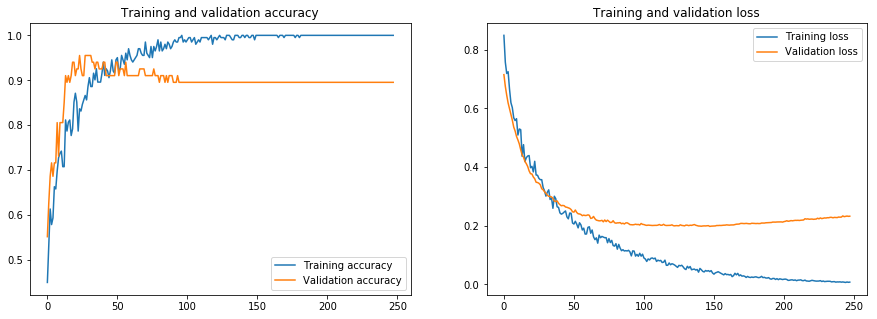

In [20]:
plot_accuracy_and_loss(history)

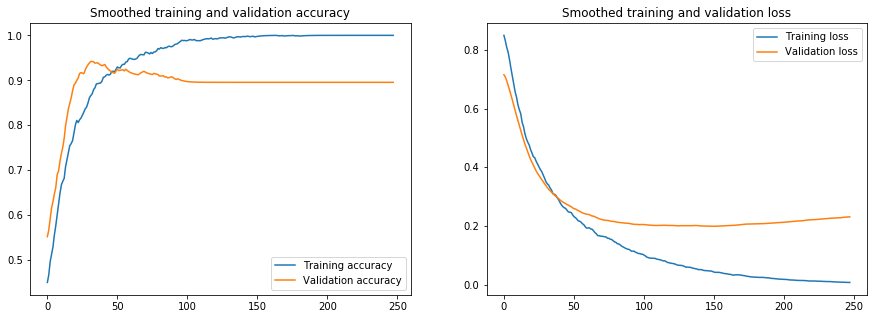

In [21]:
plot_smoothed_acc_and_loss(history, 0.8)

# 3 breeds

### Data preparation

In [7]:
classes = ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog']

train_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    PATH + train_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

validation_generator = test_datagen.flow_from_directory(
    PATH + validation_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

test_generator = test_datagen.flow_from_directory(
    PATH + test_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

# Get class labels
inv_class_indices = {v: k for k, v in train_generator.class_indices.items()}
classes_labels = []
for i in range(len(inv_class_indices)):
    classes_labels.append(inv_class_indices[i])
print('\nStored classes labels in classes_labels: ', classes_labels)

Found 353 images belonging to 3 classes.
Found 117 images belonging to 3 classes.
Found 119 images belonging to 3 classes.

Stored classes labels in classes_labels:  ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog']


### Model

In [8]:
conv_base = VGG16(weights='imagenet', 
                  include_top = False,
                  input_shape = (STD_SIZE[0], STD_SIZE[1], 3))

In [9]:
train_features, train_labels = extract_features(
    generator=train_generator, 
    feature_size=(3, 3, 512), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels),
    model=conv_base)

validation_features, validation_labels = extract_features(
    generator=validation_generator, 
    feature_size=(3, 3, 512), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels),
    model=conv_base)

test_features, test_labels = extract_features(
    generator=test_generator, 
    feature_size=(3, 3, 512), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels),
    model=conv_base)

train_features = np.reshape(train_features, (-1, 3 * 3 * 512))
validation_features = np.reshape(validation_features, (-1, 3 * 3 * 512))
test_features = np.reshape(test_features, (-1, 3 * 3 * 512))

In [10]:
model = Sequential()
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(classes_labels), activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=1e-5),
              metrics=['accuracy'])

history = model.fit(
    train_features, train_labels,
    epochs=1000, batch_size=BATCH_SIZE, verbose=2,
    validation_data=(validation_features, validation_labels),
    callbacks=[History(),
               ModelCheckpoint(PATH + 'tl_freeze_conv_base_3', monitor='val_loss', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True, verbose=1)
              ])

with open(PATH + 'tl_freeze_conv_base_3_history', 'wb') as f:
    pickle.dump(history.history, f)

W0703 00:39:00.805943  7752 deprecation_wrapper.py:119] From c:\users\serphone\envs\ds_libs_tuto\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0703 00:39:00.820944  7752 deprecation.py:506] From c:\users\serphone\envs\ds_libs_tuto\lib\site-packages\keras\backend\tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0703 00:39:00.936950  7752 deprecation.py:323] From c:\users\serphone\envs\ds_libs_tuto\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 353 samples, validate on 117 samples
Epoch 1/1000
 - 1s - loss: 1.2835 - acc: 0.3683 - val_loss: 1.0465 - val_acc: 0.4444

Epoch 00001: val_loss improved from inf to 1.04649, saving model to tl_freeze_conv_base_3
Epoch 2/1000
 - 0s - loss: 1.1552 - acc: 0.4079 - val_loss: 0.9992 - val_acc: 0.5214

Epoch 00002: val_loss improved from 1.04649 to 0.99925, saving model to tl_freeze_conv_base_3
Epoch 3/1000
 - 0s - loss: 1.1276 - acc: 0.4193 - val_loss: 0.9593 - val_acc: 0.5299

Epoch 00003: val_loss improved from 0.99925 to 0.95932, saving model to tl_freeze_conv_base_3
Epoch 4/1000
 - 0s - loss: 1.0893 - acc: 0.4561 - val_loss: 0.9212 - val_acc: 0.5812

Epoch 00004: val_loss improved from 0.95932 to 0.92115, saving model to tl_freeze_conv_base_3
Epoch 5/1000
 - 0s - loss: 0.9957 - acc: 0.5156 - val_loss: 0.8855 - val_acc: 0.6410

Epoch 00005: val_loss improved from 0.92115 to 0.88550, saving model to tl_freeze_conv_base_3
Epoch 6/1000
 - 0s - loss: 0.9262 - acc: 0.5326 - val_loss


Epoch 00046: val_loss improved from 0.45044 to 0.44706, saving model to tl_freeze_conv_base_3
Epoch 47/1000
 - 0s - loss: 0.3409 - acc: 0.9178 - val_loss: 0.4491 - val_acc: 0.8376

Epoch 00047: val_loss did not improve from 0.44706
Epoch 48/1000
 - 0s - loss: 0.3260 - acc: 0.9178 - val_loss: 0.4424 - val_acc: 0.8376

Epoch 00048: val_loss improved from 0.44706 to 0.44240, saving model to tl_freeze_conv_base_3
Epoch 49/1000
 - 0s - loss: 0.3051 - acc: 0.9263 - val_loss: 0.4383 - val_acc: 0.8376

Epoch 00049: val_loss improved from 0.44240 to 0.43827, saving model to tl_freeze_conv_base_3
Epoch 50/1000
 - 0s - loss: 0.3354 - acc: 0.9065 - val_loss: 0.4372 - val_acc: 0.8376

Epoch 00050: val_loss improved from 0.43827 to 0.43716, saving model to tl_freeze_conv_base_3
Epoch 51/1000
 - 0s - loss: 0.2976 - acc: 0.9292 - val_loss: 0.4338 - val_acc: 0.8376

Epoch 00051: val_loss improved from 0.43716 to 0.43382, saving model to tl_freeze_conv_base_3
Epoch 52/1000
 - 0s - loss: 0.2935 - acc: 0

 - 0s - loss: 0.1512 - acc: 0.9802 - val_loss: 0.3709 - val_acc: 0.8547

Epoch 00095: val_loss improved from 0.37334 to 0.37094, saving model to tl_freeze_conv_base_3
Epoch 96/1000
 - 0s - loss: 0.1449 - acc: 0.9802 - val_loss: 0.3718 - val_acc: 0.8547

Epoch 00096: val_loss did not improve from 0.37094
Epoch 97/1000
 - 0s - loss: 0.1407 - acc: 0.9802 - val_loss: 0.3698 - val_acc: 0.8462

Epoch 00097: val_loss improved from 0.37094 to 0.36980, saving model to tl_freeze_conv_base_3
Epoch 98/1000
 - 0s - loss: 0.1340 - acc: 0.9830 - val_loss: 0.3686 - val_acc: 0.8632

Epoch 00098: val_loss improved from 0.36980 to 0.36862, saving model to tl_freeze_conv_base_3
Epoch 99/1000
 - 0s - loss: 0.1302 - acc: 0.9915 - val_loss: 0.3696 - val_acc: 0.8547

Epoch 00099: val_loss did not improve from 0.36862
Epoch 100/1000
 - 0s - loss: 0.1401 - acc: 0.9802 - val_loss: 0.3701 - val_acc: 0.8547

Epoch 00100: val_loss did not improve from 0.36862
Epoch 101/1000
 - 0s - loss: 0.1169 - acc: 0.9830 - val_

 - 0s - loss: 0.0519 - acc: 1.0000 - val_loss: 0.3470 - val_acc: 0.8547

Epoch 00148: val_loss did not improve from 0.34595
Epoch 149/1000
 - 0s - loss: 0.0575 - acc: 0.9943 - val_loss: 0.3457 - val_acc: 0.8462

Epoch 00149: val_loss improved from 0.34595 to 0.34566, saving model to tl_freeze_conv_base_3
Epoch 150/1000
 - 0s - loss: 0.0534 - acc: 0.9972 - val_loss: 0.3472 - val_acc: 0.8547

Epoch 00150: val_loss did not improve from 0.34566
Epoch 151/1000
 - 0s - loss: 0.0529 - acc: 0.9972 - val_loss: 0.3463 - val_acc: 0.8547

Epoch 00151: val_loss did not improve from 0.34566
Epoch 152/1000
 - 0s - loss: 0.0534 - acc: 1.0000 - val_loss: 0.3449 - val_acc: 0.8462

Epoch 00152: val_loss improved from 0.34566 to 0.34487, saving model to tl_freeze_conv_base_3
Epoch 153/1000
 - 0s - loss: 0.0534 - acc: 0.9943 - val_loss: 0.3436 - val_acc: 0.8632

Epoch 00153: val_loss improved from 0.34487 to 0.34362, saving model to tl_freeze_conv_base_3
Epoch 154/1000
 - 0s - loss: 0.0575 - acc: 0.9972 - 


Epoch 00204: val_loss did not improve from 0.34117
Epoch 205/1000
 - 0s - loss: 0.0213 - acc: 1.0000 - val_loss: 0.3459 - val_acc: 0.8632

Epoch 00205: val_loss did not improve from 0.34117
Epoch 206/1000
 - 0s - loss: 0.0235 - acc: 1.0000 - val_loss: 0.3479 - val_acc: 0.8462

Epoch 00206: val_loss did not improve from 0.34117
Epoch 207/1000
 - 0s - loss: 0.0216 - acc: 1.0000 - val_loss: 0.3493 - val_acc: 0.8547

Epoch 00207: val_loss did not improve from 0.34117
Epoch 208/1000
 - 0s - loss: 0.0217 - acc: 1.0000 - val_loss: 0.3452 - val_acc: 0.8632

Epoch 00208: val_loss did not improve from 0.34117
Epoch 209/1000
 - 0s - loss: 0.0174 - acc: 1.0000 - val_loss: 0.3486 - val_acc: 0.8547

Epoch 00209: val_loss did not improve from 0.34117
Epoch 210/1000
 - 0s - loss: 0.0193 - acc: 1.0000 - val_loss: 0.3449 - val_acc: 0.8632

Epoch 00210: val_loss did not improve from 0.34117
Epoch 211/1000
 - 0s - loss: 0.0211 - acc: 1.0000 - val_loss: 0.3450 - val_acc: 0.8547

Epoch 00211: val_loss did 


Epoch 00263: val_loss did not improve from 0.34117
Epoch 264/1000
 - 0s - loss: 0.0084 - acc: 1.0000 - val_loss: 0.3606 - val_acc: 0.8547

Epoch 00264: val_loss did not improve from 0.34117
Epoch 265/1000
 - 0s - loss: 0.0075 - acc: 1.0000 - val_loss: 0.3618 - val_acc: 0.8547

Epoch 00265: val_loss did not improve from 0.34117
Epoch 266/1000
 - 0s - loss: 0.0073 - acc: 1.0000 - val_loss: 0.3589 - val_acc: 0.8547

Epoch 00266: val_loss did not improve from 0.34117
Epoch 267/1000
 - 0s - loss: 0.0091 - acc: 1.0000 - val_loss: 0.3558 - val_acc: 0.8718

Epoch 00267: val_loss did not improve from 0.34117
Epoch 268/1000
 - 0s - loss: 0.0076 - acc: 1.0000 - val_loss: 0.3582 - val_acc: 0.8547

Epoch 00268: val_loss did not improve from 0.34117
Epoch 269/1000
 - 0s - loss: 0.0073 - acc: 1.0000 - val_loss: 0.3587 - val_acc: 0.8632

Epoch 00269: val_loss did not improve from 0.34117
Epoch 270/1000
 - 0s - loss: 0.0063 - acc: 1.0000 - val_loss: 0.3591 - val_acc: 0.8547

Epoch 00270: val_loss did 

### Results

In [11]:
model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE)

119/119 [==============================] - 0s 126us/step


[0.43205371023226186, 0.8403361349546609]

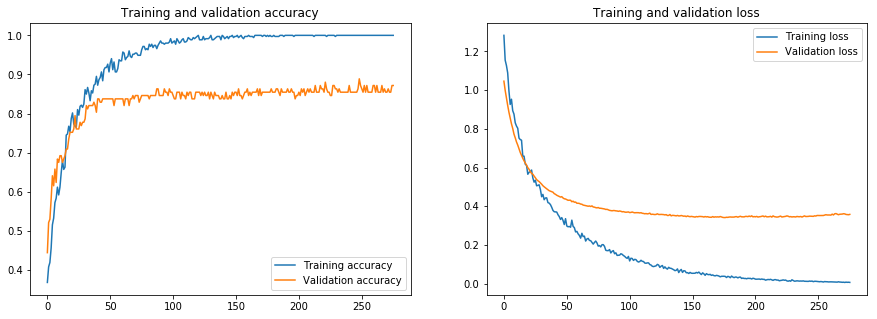

In [12]:
plot_accuracy_and_loss(history)

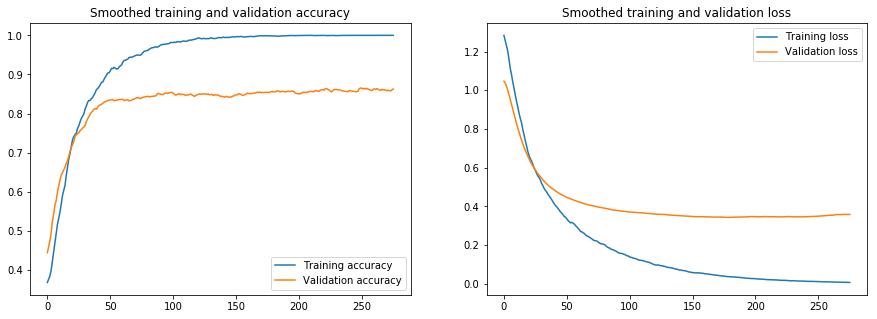

In [13]:
plot_smoothed_acc_and_loss(history, 0.8)

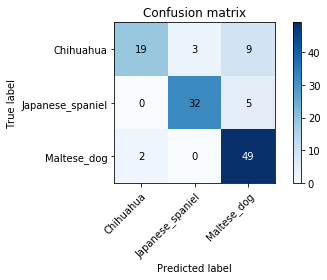

In [14]:
plot_confusion_matrix(y_true=np.argmax(test_labels, axis=-1), 
                      y_pred=model.predict_classes(test_features), 
                      classes=classes_labels)
plt.show()

# 5 breeds

### Data preparation

In [3]:
classes = ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog', 'Pekinese', 'Shih']

train_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    PATH + train_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

validation_generator = test_datagen.flow_from_directory(
    PATH + validation_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

test_generator = test_datagen.flow_from_directory(
    PATH + test_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

# Get class labels
inv_class_indices = {v: k for k, v in train_generator.class_indices.items()}
classes_labels = []
for i in range(len(inv_class_indices)):
    classes_labels.append(inv_class_indices[i])
print('\nStored classes labels in classes_labels: ', classes_labels)

Found 570 images belonging to 5 classes.
Found 190 images belonging to 5 classes.
Found 192 images belonging to 5 classes.

Stored classes labels in classes_labels:  ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog', 'Pekinese', 'Shih']


### Model

In [4]:
conv_base = VGG16(weights='imagenet', 
                  include_top = False,
                  input_shape = (STD_SIZE[0], STD_SIZE[1], 3))

W0628 16:47:27.584526  6736 deprecation_wrapper.py:119] From c:\users\serphone\envs\ds_libs_tuto\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0628 16:47:27.601526  6736 deprecation_wrapper.py:119] From c:\users\serphone\envs\ds_libs_tuto\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0628 16:47:27.603527  6736 deprecation_wrapper.py:119] From c:\users\serphone\envs\ds_libs_tuto\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0628 16:47:27.624528  6736 deprecation_wrapper.py:119] From c:\users\serphone\envs\ds_libs_tuto\lib\site-packages\keras\backend\tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0628 16:47:27.893543  6736 depreca

In [5]:
train_features, train_labels = extract_features(
    generator=train_generator, 
    feature_size=(3, 3, 512), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels),
    model=conv_base)

validation_features, validation_labels = extract_features(
    generator=validation_generator, 
    feature_size=(3, 3, 512), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels),
    model=conv_base)

test_features, test_labels = extract_features(
    generator=test_generator, 
    feature_size=(3, 3, 512), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels),
    model=conv_base)

train_features = np.reshape(train_features, (-1, 3 * 3 * 512))
validation_features = np.reshape(validation_features, (-1, 3 * 3 * 512))
test_features = np.reshape(test_features, (-1, 3 * 3 * 512))

In [7]:
model = Sequential()
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(classes_labels), activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=1e-5),
              metrics=['accuracy'])

history = model.fit(
    train_features, train_labels,
    epochs=1000, batch_size=BATCH_SIZE, verbose=2,
    validation_data=(validation_features, validation_labels),
    callbacks=[History(),
               ModelCheckpoint(PATH + 'tl_freeze_conv_base_5', monitor='val_loss', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True, verbose=1)
              ])

with open(PATH + 'tl_freeze_conv_base_5_history', 'wb') as f:
    pickle.dump(history.history, f)

W0628 16:48:03.358572  6736 deprecation_wrapper.py:119] From c:\users\serphone\envs\ds_libs_tuto\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0628 16:48:03.376573  6736 deprecation.py:506] From c:\users\serphone\envs\ds_libs_tuto\lib\site-packages\keras\backend\tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0628 16:48:03.473578  6736 deprecation.py:323] From c:\users\serphone\envs\ds_libs_tuto\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 570 samples, validate on 190 samples
Epoch 1/1000
 - 2s - loss: 1.9178 - acc: 0.2263 - val_loss: 1.5610 - val_acc: 0.2579

Epoch 00001: val_loss improved from inf to 1.56096, saving model to tl_freeze_conv_base_5
Epoch 2/1000
 - 0s - loss: 1.7652 - acc: 0.2561 - val_loss: 1.5145 - val_acc: 0.3053

Epoch 00002: val_loss improved from 1.56096 to 1.51450, saving model to tl_freeze_conv_base_5
Epoch 3/1000
 - 0s - loss: 1.7347 - acc: 0.2702 - val_loss: 1.4791 - val_acc: 0.3789

Epoch 00003: val_loss improved from 1.51450 to 1.47913, saving model to tl_freeze_conv_base_5
Epoch 4/1000
 - 0s - loss: 1.7196 - acc: 0.2825 - val_loss: 1.4467 - val_acc: 0.4053

Epoch 00004: val_loss improved from 1.47913 to 1.44665, saving model to tl_freeze_conv_base_5
Epoch 5/1000
 - 0s - loss: 1.6276 - acc: 0.2947 - val_loss: 1.4158 - val_acc: 0.4632

Epoch 00005: val_loss improved from 1.44665 to 1.41576, saving model to tl_freeze_conv_base_5
Epoch 6/1000
 - 0s - loss: 1.5455 - acc: 0.3316 - val_loss


Epoch 00046: val_loss improved from 0.99679 to 0.99176, saving model to tl_freeze_conv_base_5
Epoch 47/1000
 - 0s - loss: 0.7874 - acc: 0.7404 - val_loss: 0.9884 - val_acc: 0.6158

Epoch 00047: val_loss improved from 0.99176 to 0.98843, saving model to tl_freeze_conv_base_5
Epoch 48/1000
 - 0s - loss: 0.7822 - acc: 0.7544 - val_loss: 0.9851 - val_acc: 0.6474

Epoch 00048: val_loss improved from 0.98843 to 0.98512, saving model to tl_freeze_conv_base_5
Epoch 49/1000
 - 0s - loss: 0.7487 - acc: 0.7702 - val_loss: 0.9823 - val_acc: 0.6316

Epoch 00049: val_loss improved from 0.98512 to 0.98227, saving model to tl_freeze_conv_base_5
Epoch 50/1000
 - 0s - loss: 0.7321 - acc: 0.7772 - val_loss: 0.9827 - val_acc: 0.6263

Epoch 00050: val_loss did not improve from 0.98227
Epoch 51/1000
 - 0s - loss: 0.7391 - acc: 0.7772 - val_loss: 0.9755 - val_acc: 0.6263

Epoch 00051: val_loss improved from 0.98227 to 0.97548, saving model to tl_freeze_conv_base_5
Epoch 52/1000
 - 0s - loss: 0.7126 - acc: 0


Epoch 00094: val_loss improved from 0.91266 to 0.91023, saving model to tl_freeze_conv_base_5
Epoch 95/1000
 - 0s - loss: 0.4187 - acc: 0.9105 - val_loss: 0.9103 - val_acc: 0.6474

Epoch 00095: val_loss did not improve from 0.91023
Epoch 96/1000
 - 0s - loss: 0.4339 - acc: 0.9123 - val_loss: 0.9138 - val_acc: 0.6474

Epoch 00096: val_loss did not improve from 0.91023
Epoch 97/1000
 - 0s - loss: 0.4221 - acc: 0.9140 - val_loss: 0.9097 - val_acc: 0.6632

Epoch 00097: val_loss improved from 0.91023 to 0.90969, saving model to tl_freeze_conv_base_5
Epoch 98/1000
 - 0s - loss: 0.4186 - acc: 0.9158 - val_loss: 0.9096 - val_acc: 0.6684

Epoch 00098: val_loss improved from 0.90969 to 0.90962, saving model to tl_freeze_conv_base_5
Epoch 99/1000
 - 0s - loss: 0.4093 - acc: 0.9246 - val_loss: 0.9078 - val_acc: 0.6632

Epoch 00099: val_loss improved from 0.90962 to 0.90776, saving model to tl_freeze_conv_base_5
Epoch 100/1000
 - 0s - loss: 0.4016 - acc: 0.9175 - val_loss: 0.9086 - val_acc: 0.6579


Epoch 00150: val_loss did not improve from 0.89914
Epoch 151/1000
 - 0s - loss: 0.2116 - acc: 0.9684 - val_loss: 0.9040 - val_acc: 0.6526

Epoch 00151: val_loss did not improve from 0.89914
Epoch 152/1000
 - 0s - loss: 0.2111 - acc: 0.9772 - val_loss: 0.9020 - val_acc: 0.6474

Epoch 00152: val_loss did not improve from 0.89914
Epoch 153/1000
 - 0s - loss: 0.2068 - acc: 0.9789 - val_loss: 0.9066 - val_acc: 0.6368

Epoch 00153: val_loss did not improve from 0.89914
Epoch 154/1000
 - 0s - loss: 0.1969 - acc: 0.9807 - val_loss: 0.9064 - val_acc: 0.6316

Epoch 00154: val_loss did not improve from 0.89914
Epoch 155/1000
 - 0s - loss: 0.2038 - acc: 0.9807 - val_loss: 0.9067 - val_acc: 0.6316

Epoch 00155: val_loss did not improve from 0.89914
Epoch 156/1000
 - 0s - loss: 0.1969 - acc: 0.9825 - val_loss: 0.9094 - val_acc: 0.6316

Epoch 00156: val_loss did not improve from 0.89914
Epoch 157/1000
 - 0s - loss: 0.1986 - acc: 0.9825 - val_loss: 0.9070 - val_acc: 0.6316

Epoch 00157: val_loss did 


Epoch 00209: val_loss did not improve from 0.89914
Epoch 210/1000
 - 0s - loss: 0.1016 - acc: 0.9912 - val_loss: 0.9447 - val_acc: 0.6579

Epoch 00210: val_loss did not improve from 0.89914
Epoch 211/1000
 - 0s - loss: 0.0986 - acc: 0.9930 - val_loss: 0.9416 - val_acc: 0.6474

Epoch 00211: val_loss did not improve from 0.89914
Epoch 212/1000
 - 0s - loss: 0.0977 - acc: 0.9965 - val_loss: 0.9431 - val_acc: 0.6526

Epoch 00212: val_loss did not improve from 0.89914
Epoch 213/1000
 - 0s - loss: 0.0969 - acc: 0.9965 - val_loss: 0.9398 - val_acc: 0.6421

Epoch 00213: val_loss did not improve from 0.89914
Epoch 214/1000
 - 0s - loss: 0.0853 - acc: 1.0000 - val_loss: 0.9498 - val_acc: 0.6421

Epoch 00214: val_loss did not improve from 0.89914
Epoch 215/1000
 - 0s - loss: 0.0883 - acc: 0.9965 - val_loss: 0.9454 - val_acc: 0.6474

Epoch 00215: val_loss did not improve from 0.89914
Epoch 216/1000
 - 0s - loss: 0.0901 - acc: 0.9930 - val_loss: 0.9537 - val_acc: 0.6474

Epoch 00216: val_loss did 

### Results

In [8]:
model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE)

192/192 [==============================] - 0s 151us/step


[1.0249132538835208, 0.6041666641831398]

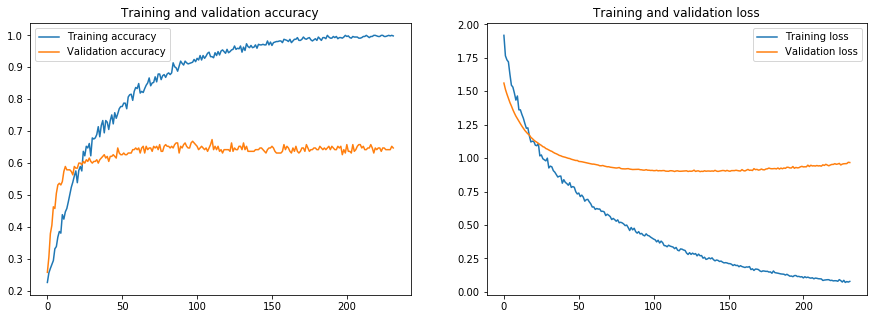

In [9]:
plot_accuracy_and_loss(history)

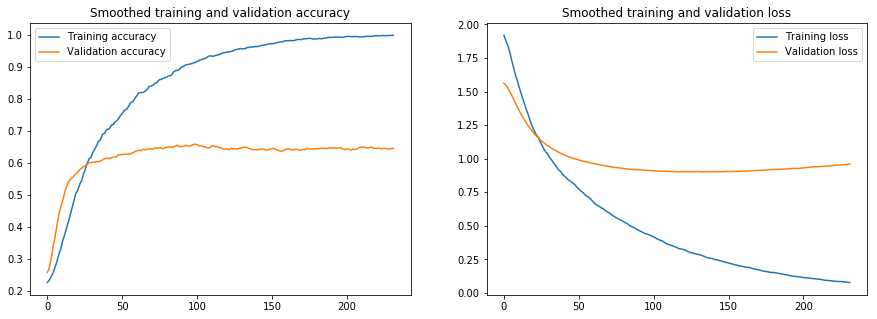

In [10]:
plot_smoothed_acc_and_loss(history, 0.8)

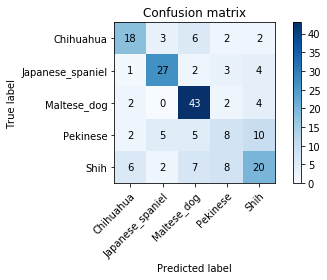

In [13]:
plot_confusion_matrix(y_true=np.argmax(test_labels, axis=-1), 
                      y_pred=model.predict_classes(test_features), 
                      classes=classes_labels)
plt.show()

# 60 breeds

### Data preparation

In [3]:
classes = os.listdir(PATH + train_dir)[:60]

train_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    PATH + train_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

validation_generator = test_datagen.flow_from_directory(
    PATH + validation_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

test_generator = test_datagen.flow_from_directory(
    PATH + test_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

# Get class labels
inv_class_indices = {v: k for k, v in train_generator.class_indices.items()}
classes_labels = []
for i in range(len(inv_class_indices)):
    classes_labels.append(inv_class_indices[i])
print('\nStored classes labels in classes_labels: ', classes_labels)

Found 6046 images belonging to 60 classes.
Found 2019 images belonging to 60 classes.
Found 2046 images belonging to 60 classes.

Stored classes labels in classes_labels:  ['affenpinscher', 'Afghan_hound', 'African_hunting_dog', 'Airedale', 'American_Staffordshire_terrier', 'Appenzeller', 'Australian_terrier', 'basenji', 'basset', 'beagle', 'Bedlington_terrier', 'Bernese_mountain_dog', 'black', 'Blenheim_spaniel', 'bloodhound', 'bluetick', 'Border_collie', 'Border_terrier', 'borzoi', 'Boston_bull', 'Bouvier_des_Flandres', 'boxer', 'Brabancon_griffon', 'briard', 'Brittany_spaniel', 'bull_mastiff', 'cairn', 'Cardigan', 'Chesapeake_Bay_retriever', 'Chihuahua', 'chow', 'clumber', 'cocker_spaniel', 'collie', 'curly', 'Dandie_Dinmont', 'dhole', 'dingo', 'Doberman', 'English_foxhound', 'English_setter', 'English_springer', 'EntleBucher', 'Eskimo_dog', 'flat', 'French_bulldog', 'German_shepherd', 'German_short', 'giant_schnauzer', 'golden_retriever', 'Gordon_setter', 'Greater_Swiss_Mountain_do

### Model

In [4]:
conv_base = VGG16(weights='imagenet', 
                  include_top = False,
                  input_shape = (STD_SIZE[0], STD_SIZE[1], 3))

W0703 00:46:18.117956  6516 deprecation_wrapper.py:119] From c:\users\serphone\envs\ds_libs_tuto\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0703 00:46:18.133957  6516 deprecation_wrapper.py:119] From c:\users\serphone\envs\ds_libs_tuto\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0703 00:46:18.136957  6516 deprecation_wrapper.py:119] From c:\users\serphone\envs\ds_libs_tuto\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0703 00:46:18.158958  6516 deprecation_wrapper.py:119] From c:\users\serphone\envs\ds_libs_tuto\lib\site-packages\keras\backend\tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0703 00:46:18.429974  6516 depreca

In [5]:
train_features, train_labels = extract_features(
    generator=train_generator, 
    feature_size=(3, 3, 512), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels),
    model=conv_base)

validation_features, validation_labels = extract_features(
    generator=validation_generator, 
    feature_size=(3, 3, 512), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels),
    model=conv_base)

test_features, test_labels = extract_features(
    generator=test_generator, 
    feature_size=(3, 3, 512), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels),
    model=conv_base)

train_features = np.reshape(train_features, (-1, 3 * 3 * 512))
validation_features = np.reshape(validation_features, (-1, 3 * 3 * 512))
test_features = np.reshape(test_features, (-1, 3 * 3 * 512))

In [6]:
model = Sequential()
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(classes_labels), activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['accuracy'])

history = model.fit(
    train_features, train_labels,
    epochs=1000, batch_size=BATCH_SIZE, verbose=2,
    validation_data=(validation_features, validation_labels),
    callbacks=[History(),
               ModelCheckpoint(PATH + 'tl_freeze_conv_base_60', monitor='val_loss', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True, verbose=1)
              ])

with open(PATH + 'tl_freeze_conv_base_60_history', 'wb') as f:
    pickle.dump(history.history, f)

W0703 00:50:14.050451  6516 deprecation_wrapper.py:119] From c:\users\serphone\envs\ds_libs_tuto\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0703 00:50:14.067451  6516 deprecation.py:506] From c:\users\serphone\envs\ds_libs_tuto\lib\site-packages\keras\backend\tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0703 00:50:14.161457  6516 deprecation.py:323] From c:\users\serphone\envs\ds_libs_tuto\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 6046 samples, validate on 2019 samples
Epoch 1/1000
 - 4s - loss: 4.1077 - acc: 0.0336 - val_loss: 3.9093 - val_acc: 0.0778

Epoch 00001: val_loss improved from inf to 3.90926, saving model to tl_freeze_conv_base_60
Epoch 2/1000
 - 3s - loss: 3.8272 - acc: 0.0850 - val_loss: 3.7163 - val_acc: 0.1050

Epoch 00002: val_loss improved from 3.90926 to 3.71632, saving model to tl_freeze_conv_base_60
Epoch 3/1000
 - 3s - loss: 3.5836 - acc: 0.1287 - val_loss: 3.5461 - val_acc: 0.1367

Epoch 00003: val_loss improved from 3.71632 to 3.54610, saving model to tl_freeze_conv_base_60
Epoch 4/1000
 - 3s - loss: 3.3524 - acc: 0.1806 - val_loss: 3.3995 - val_acc: 0.1669

Epoch 00004: val_loss improved from 3.54610 to 3.39947, saving model to tl_freeze_conv_base_60
Epoch 5/1000
 - 3s - loss: 3.1723 - acc: 0.2149 - val_loss: 3.2947 - val_acc: 0.1882

Epoch 00005: val_loss improved from 3.39947 to 3.29469, saving model to tl_freeze_conv_base_60
Epoch 6/1000
 - 3s - loss: 2.9807 - acc: 0.2499 - v

 - 3s - loss: 0.2396 - acc: 0.9542 - val_loss: 3.4393 - val_acc: 0.2660

Epoch 00055: val_loss did not improve from 2.86921
Epoch 56/1000
 - 3s - loss: 0.2221 - acc: 0.9606 - val_loss: 3.4523 - val_acc: 0.2595

Epoch 00056: val_loss did not improve from 2.86921
Epoch 57/1000
 - 3s - loss: 0.2091 - acc: 0.9663 - val_loss: 3.4659 - val_acc: 0.2551

Epoch 00057: val_loss did not improve from 2.86921
Epoch 58/1000
 - 3s - loss: 0.1937 - acc: 0.9668 - val_loss: 3.4843 - val_acc: 0.2655

Epoch 00058: val_loss did not improve from 2.86921
Epoch 59/1000
 - 3s - loss: 0.1892 - acc: 0.9714 - val_loss: 3.5434 - val_acc: 0.2556

Epoch 00059: val_loss did not improve from 2.86921
Epoch 60/1000
 - 3s - loss: 0.1901 - acc: 0.9626 - val_loss: 3.5061 - val_acc: 0.2571

Epoch 00060: val_loss did not improve from 2.86921
Epoch 61/1000
 - 3s - loss: 0.1803 - acc: 0.9694 - val_loss: 3.5564 - val_acc: 0.2531

Epoch 00061: val_loss did not improve from 2.86921
Epoch 62/1000
 - 3s - loss: 0.1619 - acc: 0.9759

### Results

In [7]:
model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE)

2046/2046 [==============================] - 0s 110us/step


[2.8751811421861397, 0.26588465356407276]

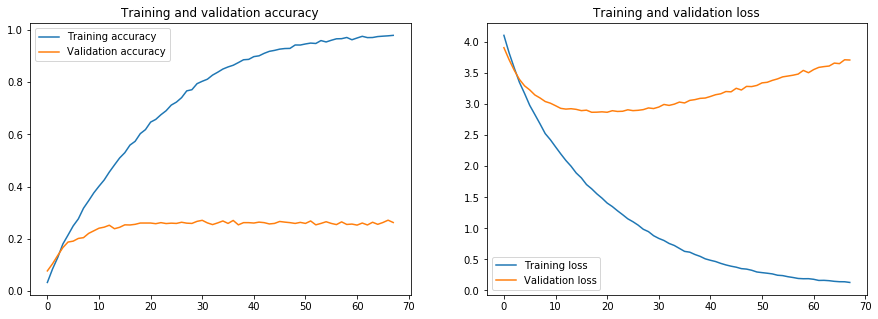

In [8]:
plot_accuracy_and_loss(history)

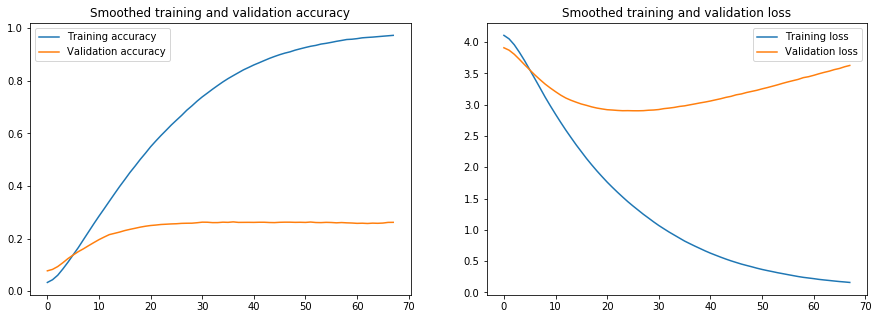

In [9]:
plot_smoothed_acc_and_loss(history, 0.8)

# 120 breeds

### Data preparation

In [3]:
train_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    PATH + train_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    PATH + validation_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    PATH + test_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical')

# Get class labels
inv_class_indices = {v: k for k, v in train_generator.class_indices.items()}
classes_labels = []
for i in range(len(inv_class_indices)):
    classes_labels.append(inv_class_indices[i])
print('\nStored classes labels in classes_labels: ', classes_labels)

Found 12307 images belonging to 120 classes.
Found 4111 images belonging to 120 classes.
Found 4162 images belonging to 120 classes.

Stored classes labels in classes_labels:  ['Afghan_hound', 'African_hunting_dog', 'Airedale', 'American_Staffordshire_terrier', 'Appenzeller', 'Australian_terrier', 'Bedlington_terrier', 'Bernese_mountain_dog', 'Blenheim_spaniel', 'Border_collie', 'Border_terrier', 'Boston_bull', 'Bouvier_des_Flandres', 'Brabancon_griffon', 'Brittany_spaniel', 'Cardigan', 'Chesapeake_Bay_retriever', 'Chihuahua', 'Dandie_Dinmont', 'Doberman', 'English_foxhound', 'English_setter', 'English_springer', 'EntleBucher', 'Eskimo_dog', 'French_bulldog', 'German_shepherd', 'German_short', 'Gordon_setter', 'Great_Dane', 'Great_Pyrenees', 'Greater_Swiss_Mountain_dog', 'Ibizan_hound', 'Irish_setter', 'Irish_terrier', 'Irish_water_spaniel', 'Irish_wolfhound', 'Italian_greyhound', 'Japanese_spaniel', 'Kerry_blue_terrier', 'Labrador_retriever', 'Lakeland_terrier', 'Leonberg', 'Lhasa', '

### Model

In [4]:
conv_base = VGG16(weights='imagenet', 
                  include_top = False,
                  input_shape = (STD_SIZE[0], STD_SIZE[1], 3))

W0629 00:51:35.847312  9204 deprecation_wrapper.py:119] From c:\users\serphone\envs\ds_libs_tuto\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0629 00:51:35.866912  9204 deprecation_wrapper.py:119] From c:\users\serphone\envs\ds_libs_tuto\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0629 00:51:35.869913  9204 deprecation_wrapper.py:119] From c:\users\serphone\envs\ds_libs_tuto\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0629 00:51:35.891914  9204 deprecation_wrapper.py:119] From c:\users\serphone\envs\ds_libs_tuto\lib\site-packages\keras\backend\tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0629 00:51:36.554736  9204 depreca

In [5]:
train_features, train_labels = extract_features(
    generator=train_generator, 
    feature_size=(3, 3, 512), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels),
    model=conv_base)

validation_features, validation_labels = extract_features(
    generator=validation_generator, 
    feature_size=(3, 3, 512), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels),
    model=conv_base)

test_features, test_labels = extract_features(
    generator=test_generator, 
    feature_size=(3, 3, 512), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels),
    model=conv_base)

train_features = np.reshape(train_features, (-1, 3 * 3 * 512))
validation_features = np.reshape(validation_features, (-1, 3 * 3 * 512))
test_features = np.reshape(test_features, (-1, 3 * 3 * 512))

In [6]:
model = Sequential()
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(classes_labels), activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=1e-5),
              metrics=['accuracy'])

history = model.fit(
    train_features, train_labels,
    epochs=1000, batch_size=BATCH_SIZE, verbose=2,
    validation_data=(validation_features, validation_labels),
    callbacks=[History(),
               ModelCheckpoint(PATH + 'tl_freeze_conv_base_120', monitor='val_loss', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True, verbose=1)
              ])

with open(PATH + 'tl_freeze_conv_base_120_history', 'wb') as f:
    pickle.dump(history.history, f)

W0629 01:00:03.064595  9204 deprecation_wrapper.py:119] From c:\users\serphone\envs\ds_libs_tuto\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0629 01:00:03.092195  9204 deprecation.py:506] From c:\users\serphone\envs\ds_libs_tuto\lib\site-packages\keras\backend\tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0629 01:00:03.210401  9204 deprecation.py:323] From c:\users\serphone\envs\ds_libs_tuto\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 12307 samples, validate on 4111 samples
Epoch 1/1000
 - 7s - loss: 5.0557 - acc: 0.0093 - val_loss: 4.7799 - val_acc: 0.0173

Epoch 00001: val_loss improved from inf to 4.77991, saving model to tl_freeze_conv_base_120
Epoch 2/1000
 - 6s - loss: 4.8013 - acc: 0.0137 - val_loss: 4.7376 - val_acc: 0.0243

Epoch 00002: val_loss improved from 4.77991 to 4.73757, saving model to tl_freeze_conv_base_120
Epoch 3/1000
 - 6s - loss: 4.7430 - acc: 0.0231 - val_loss: 4.7104 - val_acc: 0.0316

Epoch 00003: val_loss improved from 4.73757 to 4.71037, saving model to tl_freeze_conv_base_120
Epoch 4/1000
 - 6s - loss: 4.7018 - acc: 0.0293 - val_loss: 4.6826 - val_acc: 0.0431

Epoch 00004: val_loss improved from 4.71037 to 4.68256, saving model to tl_freeze_conv_base_120
Epoch 5/1000
 - 6s - loss: 4.6567 - acc: 0.0342 - val_loss: 4.6474 - val_acc: 0.0482

Epoch 00005: val_loss improved from 4.68256 to 4.64744, saving model to tl_freeze_conv_base_120
Epoch 6/1000
 - 6s - loss: 4.6199 - acc: 0.03

 - 6s - loss: 3.2336 - acc: 0.2537 - val_loss: 3.6735 - val_acc: 0.1637

Epoch 00046: val_loss improved from 3.68519 to 3.67355, saving model to tl_freeze_conv_base_120
Epoch 47/1000
 - 6s - loss: 3.2233 - acc: 0.2519 - val_loss: 3.6637 - val_acc: 0.1640

Epoch 00047: val_loss improved from 3.67355 to 3.66367, saving model to tl_freeze_conv_base_120
Epoch 48/1000
 - 6s - loss: 3.1878 - acc: 0.2623 - val_loss: 3.6535 - val_acc: 0.1674

Epoch 00048: val_loss improved from 3.66367 to 3.65354, saving model to tl_freeze_conv_base_120
Epoch 49/1000
 - 6s - loss: 3.1676 - acc: 0.2666 - val_loss: 3.6427 - val_acc: 0.1671

Epoch 00049: val_loss improved from 3.65354 to 3.64268, saving model to tl_freeze_conv_base_120
Epoch 50/1000
 - 6s - loss: 3.1485 - acc: 0.2709 - val_loss: 3.6354 - val_acc: 0.1720

Epoch 00050: val_loss improved from 3.64268 to 3.63538, saving model to tl_freeze_conv_base_120
Epoch 51/1000
 - 6s - loss: 3.1248 - acc: 0.2763 - val_loss: 3.6245 - val_acc: 0.1683

Epoch 00051:

 - 6s - loss: 2.4294 - acc: 0.4293 - val_loss: 3.4142 - val_acc: 0.2004

Epoch 00091: val_loss improved from 3.41808 to 3.41423, saving model to tl_freeze_conv_base_120
Epoch 92/1000
 - 6s - loss: 2.4182 - acc: 0.4220 - val_loss: 3.4117 - val_acc: 0.1985

Epoch 00092: val_loss improved from 3.41423 to 3.41174, saving model to tl_freeze_conv_base_120
Epoch 93/1000
 - 6s - loss: 2.4027 - acc: 0.4269 - val_loss: 3.4086 - val_acc: 0.1985

Epoch 00093: val_loss improved from 3.41174 to 3.40861, saving model to tl_freeze_conv_base_120
Epoch 94/1000
 - 6s - loss: 2.3882 - acc: 0.4328 - val_loss: 3.4064 - val_acc: 0.1980

Epoch 00094: val_loss improved from 3.40861 to 3.40643, saving model to tl_freeze_conv_base_120
Epoch 95/1000
 - 6s - loss: 2.3744 - acc: 0.4377 - val_loss: 3.4046 - val_acc: 0.2009

Epoch 00095: val_loss improved from 3.40643 to 3.40457, saving model to tl_freeze_conv_base_120
Epoch 96/1000
 - 6s - loss: 2.3660 - acc: 0.4389 - val_loss: 3.4006 - val_acc: 0.2007

Epoch 00096:


Epoch 00139: val_loss did not improve from 3.35633
Epoch 140/1000
 - 6s - loss: 1.8199 - acc: 0.5679 - val_loss: 3.3566 - val_acc: 0.2107

Epoch 00140: val_loss did not improve from 3.35633
Epoch 141/1000
 - 6s - loss: 1.8189 - acc: 0.5732 - val_loss: 3.3575 - val_acc: 0.2075

Epoch 00141: val_loss did not improve from 3.35633
Epoch 142/1000
 - 6s - loss: 1.8000 - acc: 0.5742 - val_loss: 3.3553 - val_acc: 0.2097

Epoch 00142: val_loss improved from 3.35633 to 3.35533, saving model to tl_freeze_conv_base_120
Epoch 143/1000
 - 6s - loss: 1.7810 - acc: 0.5832 - val_loss: 3.3584 - val_acc: 0.2131

Epoch 00143: val_loss did not improve from 3.35533
Epoch 144/1000
 - 6s - loss: 1.7828 - acc: 0.5795 - val_loss: 3.3548 - val_acc: 0.2111

Epoch 00144: val_loss improved from 3.35533 to 3.35481, saving model to tl_freeze_conv_base_120
Epoch 145/1000
 - 6s - loss: 1.7728 - acc: 0.5840 - val_loss: 3.3565 - val_acc: 0.2124

Epoch 00145: val_loss did not improve from 3.35481
Epoch 146/1000
 - 6s - l

 - 6s - loss: 1.2825 - acc: 0.7133 - val_loss: 3.4020 - val_acc: 0.2170

Epoch 00198: val_loss did not improve from 3.35481
Epoch 199/1000
 - 6s - loss: 1.2722 - acc: 0.7132 - val_loss: 3.4041 - val_acc: 0.2177

Epoch 00199: val_loss did not improve from 3.35481
Epoch 200/1000
 - 6s - loss: 1.2556 - acc: 0.7143 - val_loss: 3.4039 - val_acc: 0.2141

Epoch 00200: val_loss did not improve from 3.35481
Epoch 201/1000
 - 6s - loss: 1.2588 - acc: 0.7146 - val_loss: 3.4052 - val_acc: 0.2133

Epoch 00201: val_loss did not improve from 3.35481
Epoch 202/1000
 - 6s - loss: 1.2552 - acc: 0.7164 - val_loss: 3.4114 - val_acc: 0.2148

Epoch 00202: val_loss did not improve from 3.35481
Epoch 203/1000
 - 6s - loss: 1.2420 - acc: 0.7213 - val_loss: 3.4132 - val_acc: 0.2170

Epoch 00203: val_loss did not improve from 3.35481
Epoch 204/1000
 - 6s - loss: 1.2496 - acc: 0.7172 - val_loss: 3.4145 - val_acc: 0.2165

Epoch 00204: val_loss did not improve from 3.35481
Epoch 205/1000
 - 6s - loss: 1.2248 - acc:

### Results

In [7]:
model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE)

4162/4162 [==============================] - 0s 106us/step


[3.3466049624657987, 0.21576165671047254]

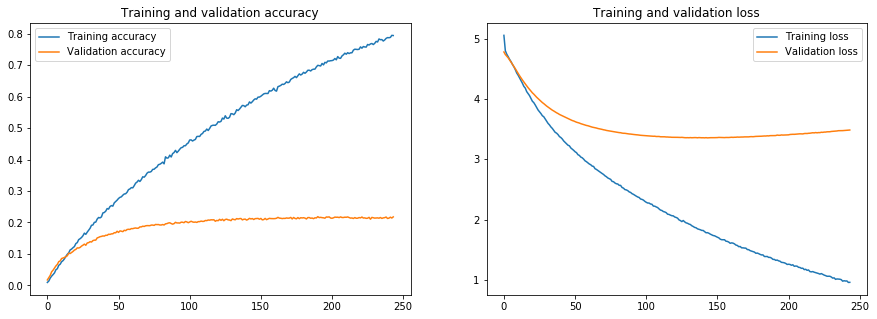

In [8]:
plot_accuracy_and_loss(history)

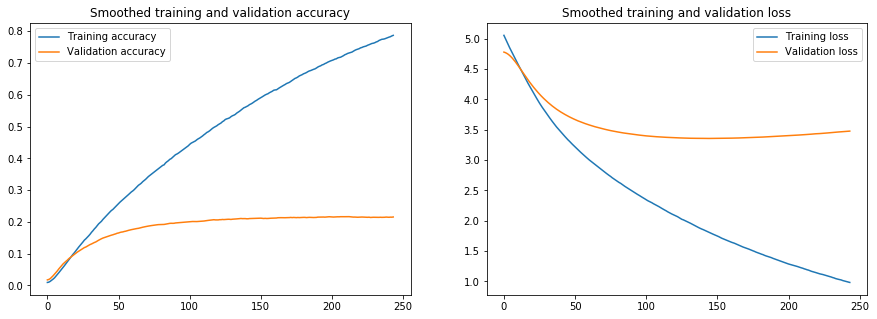

In [9]:
plot_smoothed_acc_and_loss(history, 0.8)